# The genetic algorithm - pathfinding with robots in a grid

### Summary

We explore the genetic algorithm in a pathfinding problem: given a virtual robot (at some position $(x,y)$) capable of receiving instructions ('move up', 'move down',...) to move in a 2D grid, what is the set of instructions we should feed it to make it reach the goal $(x', y')$? (We do not care if the path is the shortest or not).   
Pathfinding problems are both interesting and useful, but there are many (better) ways to deal with them.
Here we use the problem as a way to explore the genetic algorithm, and to see it in action in a geometrical and intuitive problem.  

The genetic algorithm mimics natural selection: [Norvig]

    1) Start with an *initial population* (of candidates to a solution), each individual having its own set of *genes* (descriptors of the solution proposal);
    2) Determine how *fit* (how close they are to truly providing a solution to the problem) the individuals in the population are;
    3) *Select* the individuals which are going to reproduce using their fitness levels: the fitter, the more likely to reproduce;
    4) Couple the selected individuals in pairs (of *parents*) and generate two *children* for each pair of parents by *crossing over* (mixing) the parents' genes;
    5) Introduce a slight *mutation* in the children genes, so that their genes are not just a mix of their parents' genes, and evolution can occur.
    6) These children are now the new population. Repeat 2) $\rightarrow$ 5) until one of the individuals solves the problem (has maximum fitness) or we reach our maximum number of iterations.

In [1]:
import py
import matplotlib.pyplot as plt
import numpy as np
import random

## Defining and visualizing a robot

Our "robots" must be at a certain position in the grid at all times, and be able to move up. down, left or right (on each step).  
We will use a 10x10 grid, meaning that the maximum number of steps one could possibly need to reach one position from another is $(10-1)\times 2=18$.
Accordingly, the set of orders that the a robot must obey will be written as a string of length 18, each character being either 'u', 'd', 'l' or 'r', corresponding to the four directions we want the robot to move in.

In [2]:
class Robot:
    '''
    A Robot moves in a 2D 10x10 grid, starting at position (x,y) and following the orders, ending at some other location of the grid.
    0<x<9, 0<y<9 are the initial (integer) coordinates.
    orders is a string of length 18 composed exclusively of the letters 'u', 'd', 'l', r', corresponding to up, down, left and right.
    '''
    def __init__(self, x, y, ID, orders):
        self.stop = False
        self.order_string = orders
        self.ID = ID #Number that labels the robot, so that we can refer to its figure.
        self.x, self.y = x, y
        self.log = np.zeros((10,10)); self.log[x,y] = 1
        self.obey(orders)
        
    def obey(self, orders):
        for l in orders:
            if l == 'r' and self.x < 9:
                self.x += 1
            elif l == 'l' and self.x > 0:
                self.x -= 1
            elif l == 'u' and self.y < 9:
                self.y += 1
            elif l == 'd' and self.y > 0:
                self.y -= 1
            self.log[self.x, self.y] += 1
        self.log[self.x, self.y] = np.max(self.log) + 2 #Highlights last location.


Notice that it is not really accurate that a robot is fed orders. Instead, it is "born" with them: its orders (a string of the type 'uddllr...rd' of length 18) can be seen as its DNA.  
This also means that the trail that the robot leaves can be seen as its fingerprint (it's clear that *usually* different orders lead to different trails). 
Let us define a function which draws the trail of a robot using a colormap.

In [3]:
def draw_trail(robot, goal):
        array = np.transpose(robot.log)
        array[goal] = robot.log[robot.x, robot.y] #Highlights goal.
        plt.figure(robot.ID)
        plt.title('robot ID: {}'.format(robot.ID))
        plt.imshow(array, origin='lower')

For each step that a robot is at a certain position, the square at that position becomes brighter (relative to the background) and changes color. The goal and the final position of the robot are the brightest, and colored yellow.

We fix the goal at (9,9) from now on, and the initial position of the robots at (0,0).

Let's take a look at the trails of two robots.

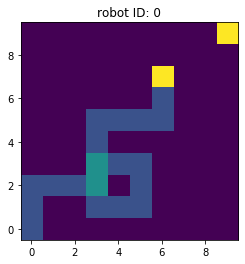

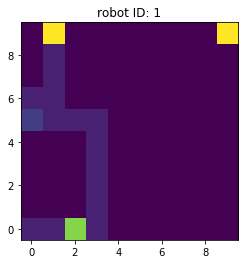

In [4]:
goal = (9, 9)

rob = Robot(0,0,0,'uurrrurrddlluuuurrruu')
draw_trail(rob, goal)

rob = Robot(0,0,1,'rrddddddddruuuuulllluruuuuuuu')
draw_trail(rob, goal)

We will use the genetic algorithm applied to order strings to arrive at a robot (with a certain order string which works as its DNA in the genetic analogy) which arrives at the goal.

## Generate initial population of robots.

Our initial population will be composed of $10$ robots.  
Again, we will take all robots to start at $(0,0)$, so that what distinguishes them (their DNA if you will) is their order strings.  

In [5]:
#These values will be used throughout the project:
global pop_number; global x; global y
pop_number = 10
x = y = 0

global max_steps; global order_string_size; global max_fitness
max_steps = order_string_size = max_fitness = 18 #It will be explained later why max_fitness has this value.

In [6]:
#Let's create the robots.
def initialize_robots(x, y, pop_number, draw=False):
    '''
    Creates a (global) list of pop_number robots with:
        initial position (x,y)
        ID = {index of the robot in the robots list}
        orders a random 18-character string of orders.
    If draw is set to True, all robot trails will be drawn.
    '''
    global robots
    robots = []
    for ID in range(pop_number):
        orders_list = random.choices(['u','d','l','r'], k=order_string_size) #List of random orders.
        orders = ''.join(orders_list) #Make it a string.
        robots.append(Robot(x, y, ID, orders))
    if draw:
        for ID in range(len(robots)):
            draw_trail(robots[ID], goal)

In [7]:
random.seed(1) #To make sure we can discuss the results consistently.
initialize_robots(x, y, pop_number)

## Distance function, fitness and selection probabilities

We have an obvious choice for our fitness score: {max_distance - the distance between the final position of the robot and the goal}, so that the robot closest to the goal has the highest fitness.  
It is clear that we do not want to use the Euclidean distance in this project.
To see this, consider the image below which represents a miniature (3x3) version of our grid.  

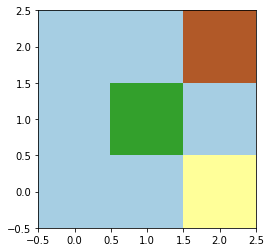

In [9]:
plt.imshow(np.array([[0,0,0.9],[0,0.3,0],[0,0,1]]), origin='lower', cmap='Paired')
#plt.savefig('images/Robots/distance.png')
plt.show()

Goal = brown; X = green, Y = yellow.  
Clearly: {Euclidean distance between X and the goal} < {Euclidean distance between Y and the goal}.  
So if we chose this distance for out fitness, we would be preferring Y over X, which makes no sense: both are 2 steps away from reaching the goal!  
This means that, since the robots move in a grid (in discrete steps and non-diagonally), we need another notion of distance to the goal which does not distinguish between these X and Y.  
There is a distance function $d_1$ that provides just that - we'll call it the "grid distance", and is given by:
$$
d_1(A,B) = \sum_i |A_i - B_i| = |A_x - B_x| + |A_y - B_y|
$$
We can use all our usual intuitions about distance since this function has all the usual properties of distances in $\mathbb R^2$ (more rigorously, $(\mathbb R^2, d_1)$ is a metric space [Sutherland], and furthermore our grid can be seen as a subset of $\mathbb R^2$).

In [59]:
def d1(X, Y):
    '''
    The (2D) grid distance between X and Y.
    '''
    return abs(X[0]-Y[0]) + abs(X[1]-Y[1]) 

In [60]:
def fitness(robot):
    '''
    Computes the fitness using the grid distance d1, so that the robot has a higher fitness the closer it is to the goal.
    '''
    X = (robot.x, robot.y)
    return max_steps - d1(X, goal) #The closer to the goal, the higher the fitness.

Having the fitness function, it is straightforward to define the probability of being selected to reproduce based on the fitness scores of the population in a natural way:
$$
P_i = \frac{f_i}{\sum_j f_j}
$$

In [62]:
def selection_prob(robot, robots):
    '''
    Probability of a robot being the selected out of all the robots, based on their fitness scores.
    '''
    fitnesses = [fitness(robot) for robot in robots]
    prob = fitness(robot)/sum(fitnesses)
    return prob

In [63]:
def selection_probs(robots):
    '''
    Returns list with the selection probabilities of all the robots.
    '''
    probs = [selection_prob(robot, robots) for robot in robots]
    return probs

Let us compute the fitness levels and selection probabilities of the initial population of robots, and visualize their trails to check that the results make sense.

Total probability: 1.0 
 
 ==== Initial population of robots: ==== 



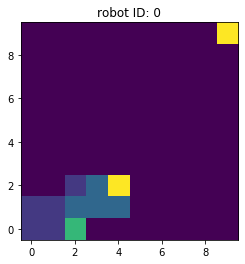

Fitness level: 0, Selection probability: 6


 


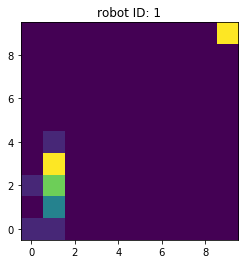

Fitness level: 1, Selection probability: 4


 


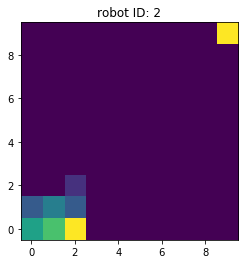

Fitness level: 2, Selection probability: 2


 


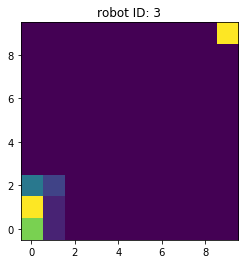

Fitness level: 3, Selection probability: 1


 


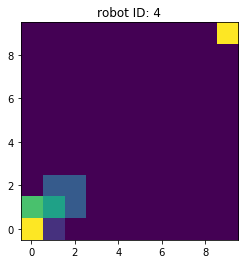

Fitness level: 4, Selection probability: 0


 


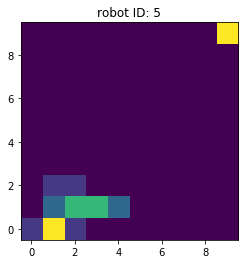

Fitness level: 5, Selection probability: 1


 


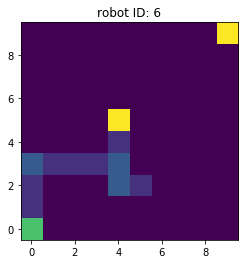

Fitness level: 6, Selection probability: 9


 


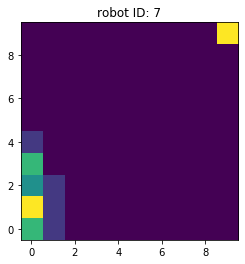

Fitness level: 7, Selection probability: 1


 


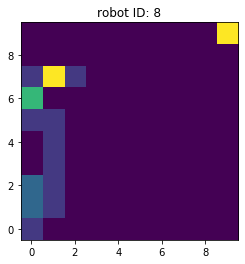

Fitness level: 8, Selection probability: 8


 


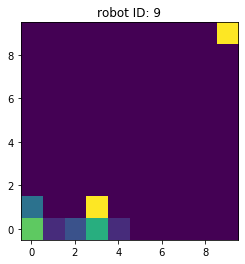

Fitness level: 9, Selection probability: 4


 


In [72]:
print( 'Total probability: {} \n \n ==== Initial population of robots: ==== \n'.format(sum(selection_probs(robots))) )
for ID in range(pop_number):
    robot = robots[ID]
    draw_trail(robot, goal)
    plt.show()
    print('Fitness level: {}, Selection probability: {}'.format(ID, fitness(robot), selection_prob(robot, robots)))
    print('\n\n ')

Notice that robots 6 and 8 have the highest selection probabilities, and indeed they are the closest robots to the goal.

## Selection

In [73]:
def selection(robots):
    '''
    robots is list with N entries containing one generation of robots (a population of robots).
    Returns a tuple:
        List of N robots, chosen according to their fitness: more fit --> more probable to be selected.
        List of IDs of the chosen robots.
    '''
    probs = selection_probs(robots) #Selection probabilities from fitness scores.
    indices = range(len(robots)) #Will choose indices (IDs) instead of robots directly, so that it's easy and efficient to know the chosen IDs.
    #Choice with replacement, to select robots on fitness:
    chosen_IDs = random.choices( population=indices, weights=probs, k=pop_number ) 
    chosen_robots = [robots[ID] for ID in chosen_IDs]
    return chosen_robots, chosen_IDs

random.seed(1) #To make sure we can discuss the results consistently.
print('Chosen IDs:', selection(robots)[1])

Chosen IDs: [0, 8, 8, 1, 6, 6, 7, 8, 0, 0]


Unsurprisingly, robots 6 and 8 are often chosen.

## Crossover

Each pair of selected robots will have two children, each of them getting part of their order string from one parent, and part from the other.  
The amount taken from each parent is randomly selected.

In [74]:
def create_children(parent1, parent2, ID1, ID2):
    '''
    Each parent is an object of the class Robot.
    Returns a pair (tuple) of child robots (with identity numbers ID1, ID2) by crossing over the genetic information (the order strings) of the parents.
    '''
    cutoff = random.randint(0, order_string_size)
    #Create first child:
    contribution_1 = parent1.order_string[0:cutoff]
    contribution_2 = parent2.order_string[cutoff:order_string_size]
    orders = contribution_1 + contribution_2
    child1 = Robot(x, y, ID1, orders)
    #Create second child (reusing the cutoff):
    contribution_1 = parent2.order_string[0:cutoff]
    contribution_2 = parent1.order_string[cutoff:order_string_size]
    orders = contribution_1 + contribution_2
    child2 = Robot(x, y, ID2, orders)
    return child1, child2

#Example:
random.seed(1) #To make sure we can discuss the results consistently.
child_example1, child_example2 = create_children(robots[0], robots[1], 500, 1000)
print('Example: \n Parent 1 order string: {} \n Parent 2 order string: {} \n Child 1 order string: {} \n Child 2 order string: {}'.format(robots[0].order_string, robots[1].order_string, child_example1.order_string, child_example2.order_string))

Example: 
 Parent 1 order string: urrdddlruurdrudlur 
 Parent 2 order string: ruulrduduudduuuddu 
 Child 1 order string: urrdrduduudduuuddu 
 Child 2 order string: ruulddlruurdrudlur


## Mutation

We will randomly mutate one gene of each child.  
To that end, we must first define a function that mutates a robot.  
The mutation will change a single (randomly chosen) gene

In [93]:
def mutate(robot):
    '''
    Returns the same" robot but with a single gene (one character of the order string) randomly mutated.
    The mutated gene is also randomly selected.
    '''
    #Original DNA:
    order_string = robot.order_string
    #Choose random gene to mutate:
    i = random.randint(0, len(order_string)-1)
    gene = order_string[i]
    #Mutate gene:
    gene = random.choice(['u', 'd', 'l', 'r']) #Notice the gene can actually remain unmutated.
    #Change DNA:
    order_list = list(order_string) #Lists are easier and more officient to handle when assigning values.
    order_list[i] = gene
    mutated_order_string = ''.join(order_list)
    #Create mutated robot, with same ID as the original:
    mutated_robot = Robot(x, y, robot.ID, mutated_order_string)
    return mutated_robot

In [94]:
#Example:
random.seed(1) #To make sure we can discuss the results consistently.
print('Original: ', robots[0].order_string)
print('Mutated: ',mutate(robots[0]).order_string)

Original:  urlurrurrrrrldulud
Mutated:  urluururrrrrldulud


Notice that it was the second 'r' that mutated into a 'u'.

## The loop: evolving the robots

iterations: 0, best fitness: 9, best distance to goal: 9


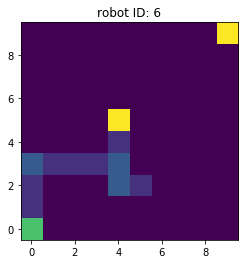

iterations: 5, best fitness: 9, best distance to goal: 9
iterations: 10, best fitness: 10, best distance to goal: 8
iterations: 15, best fitness: 9, best distance to goal: 9
iterations: 20, best fitness: 9, best distance to goal: 9


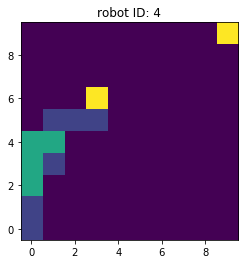

iterations: 25, best fitness: 10, best distance to goal: 8
iterations: 30, best fitness: 11, best distance to goal: 7
iterations: 35, best fitness: 14, best distance to goal: 4
iterations: 40, best fitness: 15, best distance to goal: 3


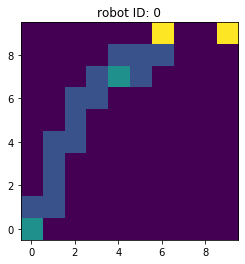

iterations: 45, best fitness: 15, best distance to goal: 3
iterations: 50, best fitness: 16, best distance to goal: 2
iterations: 55, best fitness: 13, best distance to goal: 5
iterations: 60, best fitness: 15, best distance to goal: 3


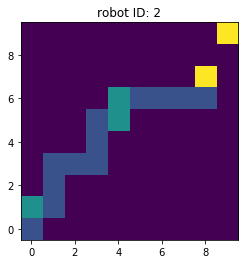

iterations: 65, best fitness: 15, best distance to goal: 3
iterations: 70, best fitness: 15, best distance to goal: 3
iterations: 75, best fitness: 13, best distance to goal: 5
iterations: 80, best fitness: 12, best distance to goal: 6


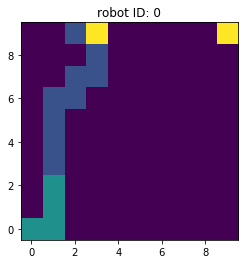

iterations: 85, best fitness: 13, best distance to goal: 5
iterations: 90, best fitness: 14, best distance to goal: 4
iterations: 95, best fitness: 11, best distance to goal: 7
iterations: 100, best fitness: 12, best distance to goal: 6


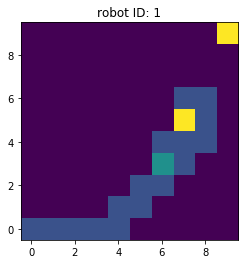

iterations: 105, best fitness: 15, best distance to goal: 3
iterations: 110, best fitness: 14, best distance to goal: 4
iterations: 115, best fitness: 14, best distance to goal: 4
iterations: 120, best fitness: 16, best distance to goal: 2


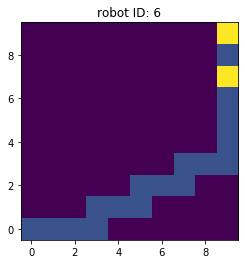

iterations: 125, best fitness: 14, best distance to goal: 4
iterations: 130, best fitness: 14, best distance to goal: 4
iterations: 135, best fitness: 15, best distance to goal: 3
Total iterations: 139, Final best fitness: 18, Final best distance to goal: 0


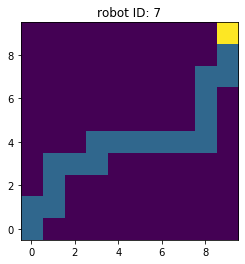

In [124]:
random.seed(1)
initialize_robots(x, y, pop_number)

#I will store all the robot generations in a list so that it is easy to analyze the results and observe the evolution throughout the generations.
robot_gens = []

#Initialize best fitness.
fitness_levels = [fitness(robot) for robot in robots]
best_robot_fitness = max(fitness_levels)

fitness_log = [] #Will be used to plot the (best) fitness against iters.

iters = 0
max_iters = 200
while best_robot_fitness < max_fitness and iters <= max_iters: #That is, while no robot finishes at the goal position.
    ########
    #Print iterations and fitness info every 5 iterations:
    if iters%5 == 0: 
        print('iterations: {}, best fitness: {}, best distance to goal: {}'.format(iters, best_robot_fitness, 18-best_robot_fitness))
        #Visualize the best robot every 20 iterations. (Notice that this sits well inside the other if statement since 20%5==0)
        if iters%20 == 0:
            #Get the best robot of this generation:
            best_robot_index = fitness_levels.index(best_robot_fitness)
            best_robot = robots[best_robot_index]
            #Draw its trail:
            draw_trail(best_robot, goal)
            #plt.savefig('images/Robots/BestRobot{}.png'.format(iters))
            plt.show()
    robot_gens.append(robots) #Add current generation (population) to the dictionary of robot generations.
    #######
    #Selection of the fittest:
    selected_robots = selection(robots)[0]
    #Create children:
    for j in range(pop_number//2): #Will have pop_number/2 pairs of parents.
        parent1 = selected_robots[j]
        parent2 = selected_robots[pop_number//2 + j] #Easy way to select parents without (explicit) repetition.
        ID1, ID2 = j, pop_number//2 + j #Children will have same IDs as parents (in selected_robots, not robots - but it doesn't matter since len(selected_robots)=len(robots).
        child1, child2 = create_children(parent1, parent2, ID1, ID2)
        ########
        #Mutation
        child1, child2 = mutate(child1), mutate(child2)
        #Update robots list to included new (mutated) generation.
        robots[ID1], robots[ID2] = child1, child2
    ########
    #Update max_fitness:
    fitness_levels = [fitness(robot) for robot in robots]
    best_robot_fitness = max(fitness_levels)
    fitness_log.append(best_robot_fitness)
    ########
    #Update iters:
    iters += 1
#Get the best robot the final generation.
best_robot_index = fitness_levels.index(best_robot_fitness)
best_robot = robots[best_robot_index]
#Draw its trail:
print('Total iterations: {}, Final best fitness: {}, Final best distance to goal: {}'.format(iters, best_robot_fitness, 18-best_robot_fitness))
draw_trail(best_robot, goal)
#plt.savefig('images/Robots/BestRobot{}.png'.format(iters))
plt.show()

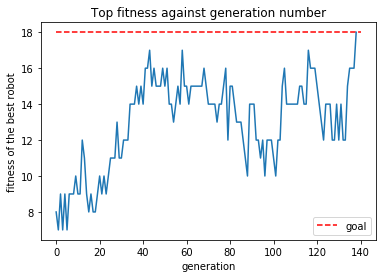

In [126]:
plt.figure()
plt.title('Top fitness against generation number')
plt.xlabel('generation')
plt.ylabel('fitness of the best robot')
plt.plot(range(iters), fitness_log)
plt.hlines(18, 0, 140, label='goal', colors='r', linestyles='--')
plt.legend(loc='lower right')
plt.savefig('images/Robots/fitness_plot.png')
plt.show()

**Note**: We can use robot_gens to easily access a specific robot. np.array(robot_gens) has as many rows as there were iterations (generations), and as many columns as there ere individuals on each generation (notice that in our implementation of the genetic algorithm the population number remains constant).

Shape of robot_gens: (139, 10)


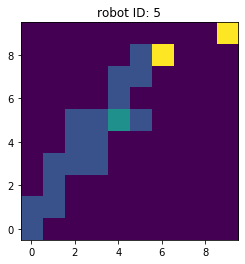

In [113]:
print('Shape of robot_gens:', np.array(robot_gens).shape)
#Let's see the trail for the sixth robot of the 100th generation.
draw_trail(robot_gens[100][5],goal)

## References

- [Norvig]: Russell, Stuart J., and Peter Norvig. *Artificial intelligence: a modern approach*. Malaysia; Pearson Education Limited,, 2016.
- [Sutherland]: Sutherland, Wilson A. Introduction to metric and topological spaces. Oxford University Press, 2009.